In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet("../../../data/data_taxi_central_based.parquet")
trip_ids_to_keep = [1398764351620000197, 1380694967620000451]
df = df[df['TRIP_ID'].isin(trip_ids_to_keep)]
df

,TRIP_ID,ORIGIN_CALL,TAXI_ID,TIMESTAMP,POLYLINE_LENGTH,LON,LAT
index,,,,,,,
20214274,1380694967620000451,19967.0,20000451,1380694967,504,-8.640432,41.147676
20214275,1380694967620000451,19967.0,20000451,1380694982,504,-8.639622,41.144274
20214276,1380694967620000451,19967.0,20000451,1380694997,504,-8.638362,41.140755
20214277,1380694967620000451,19967.0,20000451,1380695012,504,-8.635878,41.137317
20214278,1380694967620000451,19967.0,20000451,1380695027,504,-8.635464,41.133564
...,...,...,...,...,...,...,...
67580730,1398764351620000197,63882.0,20000197,1398771806,502,-8.582418,41.178528
67580731,1398764351620000197,63882.0,20000197,1398771821,502,-8.582535,41.178600
67580732,1398764351620000197,63882.0,20000197,1398771836,502,-8.582202,41.179617


In [3]:
import timesfm

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)].


In [4]:
df_lon = df.drop(columns=['ORIGIN_CALL', 'TAXI_ID', 'POLYLINE_LENGTH', 'LAT'])
df_lat = df.drop(columns=['ORIGIN_CALL', 'TAXI_ID', 'POLYLINE_LENGTH', 'LON'])

In [5]:
import torch

In [6]:
tfm_lat = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=20,
          num_layers=50,
          use_positional_embedding=False,
          context_len=256,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(path="timesfm_predictions_LAT.ckpt", type="torch"),
  )

In [7]:
tfm_lon = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=20,
          num_layers=50,
          use_positional_embedding=False,
          context_len=256,
      ),
    checkpoint=timesfm.TimesFmCheckpoint(path="timesfm_predictions_LON.ckpt", type="torch"),
  )

In [8]:
df_lat = df_lat.sort_values(by=['TRIP_ID', 'TIMESTAMP'])
df_lat_test = df_lat.groupby('TRIP_ID', group_keys=False).tail(20)
df_lat_train = df_lat.drop(df_lat_test.index)

In [9]:
df_lon = df_lon.sort_values(by=['TRIP_ID', 'TIMESTAMP'])
df_lon_test = df_lon.groupby('TRIP_ID', group_keys=False).tail(20)
df_lon_train = df_lon.drop(df_lat_test.index)

In [10]:
import joblib
scaler_lat = joblib.load("scaler_LAT.pkl")
scaler_lon = joblib.load("scaler_LON.pkl")

df_lat_train['LAT'] = scaler_lat.fit_transform(df_lat_train[['LAT']])
df_lon_train['LON'] = scaler_lon.fit_transform(df_lon_train[['LON']])

In [11]:
df_lat_train['TIMESTAMP'] = pd.to_datetime(df_lat_train['TIMESTAMP'], unit='s')
df_lon_train['TIMESTAMP'] = pd.to_datetime(df_lon_train['TIMESTAMP'], unit='s')

In [12]:
df_lon_train = df_lon_train.rename(columns={'TIMESTAMP': 'ds', 'LON': 'y', 'TRIP_ID': 'unique_id'})
df_lat_train = df_lat_train.rename(columns={'TIMESTAMP': 'ds', 'LAT': 'y', 'TRIP_ID': 'unique_id'})

In [13]:
forecast_df_lon = tfm_lon.forecast_on_df(
    inputs=df_lon_train,
    freq="15s",
    value_name="y",
    num_jobs=-1,
)

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


In [14]:
forecast_df_lat = tfm_lon.forecast_on_df(
    inputs=df_lat_train,
    freq="15s",
    value_name="y",
    num_jobs=-1,
)

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


In [15]:
forecast_df_lon_keep = forecast_df_lon[['unique_id', 'ds', 'timesfm-q-0.9']]

In [16]:
forecast_df_lat_keep = forecast_df_lat[['unique_id', 'ds', 'timesfm-q-0.9']]

In [17]:
forecast_df_lat_keep['timesfm-q-0.9'] = scaler_lat.inverse_transform(forecast_df_lat_keep[['timesfm-q-0.9']])
forecast_df_lon_keep['timesfm-q-0.9'] = scaler_lon.inverse_transform(forecast_df_lon_keep[['timesfm-q-0.9']])

C:\Users\Nikola\AppData\Local\Temp\ipykernel_492\3587103272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df_lat_keep['timesfm-q-0.9'] = scaler_lat.inverse_transform(forecast_df_lat_keep[['timesfm-q-0.9']])
C:\Users\Nikola\AppData\Local\Temp\ipykernel_492\3587103272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df_lon_keep['timesfm-q-0.9'] = scaler_lon.inverse_transform(forecast_df_lon_keep[['timesfm-q-0.9']])


In [18]:
forecast_df_lat_keep = forecast_df_lat_keep.rename(columns={'timesfm-q-0.9': 'LAT_PREDICTED'})
forecast_df_lon_keep = forecast_df_lon_keep.rename(columns={'timesfm-q-0.9': 'LON_PREDICTED'})

In [19]:
forecast_df_lat_keep = forecast_df_lat_keep.sort_values(['unique_id', 'ds'])
forecast_df_lat_keep = forecast_df_lat_keep.groupby('unique_id').tail(1)

forecast_df_lon_keep = forecast_df_lon_keep.sort_values(['unique_id', 'ds'])
forecast_df_lon_keep = forecast_df_lon_keep.groupby('unique_id').tail(1)

In [20]:
df_lon_test = df_lon_test.rename(columns={'TIMESTAMP': 'ds', 'TRIP_ID': 'unique_id'})
df_lon_test = df_lon_test.sort_values(['unique_id', 'ds'])
df_lon_test = df_lon_test.groupby('unique_id').tail(1)

df_lat_test = df_lat_test.rename(columns={'TIMESTAMP': 'ds', 'TRIP_ID': 'unique_id'})
df_lat_test = df_lat_test.sort_values(['unique_id', 'ds'])
df_lat_test = df_lat_test.groupby('unique_id').tail(1)

In [21]:
result_lat = df_lat_test.merge(forecast_df_lat_keep, how='left', on=['unique_id'])
result_lon = df_lon_test.merge(forecast_df_lon_keep, how='left', on=['unique_id'])
result = result_lat.merge(result_lon, how='left', on=['unique_id'])

In [22]:
from evaluation_script import haversine_distance

In [23]:
result['DISTANCE_DELTA_SEPARATED'] = result.apply(lambda row: haversine_distance(
    row['LAT'], row['LON'], row['LAT_PREDICTED'], row['LON_PREDICTED']), axis=1)

In [24]:
result['DISTANCE_DELTA_SEPARATED'].mean()

np.float64(3.995974982669308)

In [25]:
result['DISTANCE_DELTA_SEPARATED'].median()

3.995974982669308

In [26]:
result.to_csv("result.csv", index=False)

In [27]:
forecast_df_lat

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,1380694967620000451,2013-10-02 08:23:47,0.998914,0.946386,0.964347,0.978765,0.988690,0.998914,1.009061,1.018444,1.029821,1.042801
1,1380694967620000451,2013-10-02 08:24:02,0.996003,0.943106,0.960447,0.975573,0.986214,0.996003,1.006366,1.016114,1.031343,1.046354
2,1380694967620000451,2013-10-02 08:24:17,0.993021,0.938234,0.956622,0.969495,0.984043,0.993021,1.004656,1.014598,1.030685,1.047885
3,1380694967620000451,2013-10-02 08:24:32,0.984666,0.923246,0.945050,0.959399,0.974025,0.984666,0.996360,1.007991,1.021940,1.042002
4,1380694967620000451,2013-10-02 08:24:47,0.990050,0.926535,0.948714,0.964204,0.980451,0.990050,1.001885,1.013303,1.028020,1.048539
5,1380694967620000451,2013-10-02 08:25:02,0.992239,0.923594,0.949260,0.966661,0.979852,0.992239,1.003255,1.015772,1.030406,1.050239
6,1380694967620000451,2013-10-02 08:25:17,0.992179,0.920083,0.949945,0.966371,0.979785,0.992179,1.003312,1.016482,1.031377,1.049616
7,1380694967620000451,2013-10-02 08:25:32,0.988927,0.916469,0.944839,0.962627,0.976882,0.988927,1.000719,1.014271,1.029978,1.047752
8,1380694967620000451,2013-10-02 08:25:47,0.989752,0.919373,0.946910,0.965094,0.978577,0.989752,1.001783,1.015340,1.031757,1.050162
9,1380694967620000451,2013-10-02 08:26:02,0.996802,0.931073,0.954064,0.972371,0.985977,0.996802,1.008888,1.022527,1.036656,1.055976


In [28]:
columns = ['timesfm-q-0.1', 'timesfm-q-0.2', 'timesfm-q-0.3', 'timesfm-q-0.4', 'timesfm-q-0.5', 'timesfm-q-0.6', 'timesfm-q-0.7', 'timesfm-q-0.8', 'timesfm-q-0.9']

In [29]:
for column in columns:
    forecast_df_lat[column] = scaler_lat.inverse_transform(forecast_df_lat[[column]])
    forecast_df_lon[column] = scaler_lon.inverse_transform(forecast_df_lon[[column]])

In [30]:
forecast_df_lat = forecast_df_lat.sort_values(['unique_id', 'ds'])
forecast_df_lat = forecast_df_lat.groupby('unique_id').tail(1)

forecast_df_lon = forecast_df_lon.sort_values(['unique_id', 'ds'])
forecast_df_lon = forecast_df_lon.groupby('unique_id').tail(1)

In [31]:
result_lat = df_lat_test.merge(forecast_df_lat, how='left', on=['unique_id'])
result_lon = df_lon_test.merge(forecast_df_lon, how='left', on=['unique_id'])
result = result_lat.merge(result_lon, how='left', on=['unique_id'])

In [32]:
result

,unique_id,ds_x_x,LAT,ds_y_x,timesfm_x,timesfm-q-0.1_x,timesfm-q-0.2_x,timesfm-q-0.3_x,timesfm-q-0.4_x,timesfm-q-0.5_x,...,timesfm_y,timesfm-q-0.1_y,timesfm-q-0.2_y,timesfm-q-0.3_y,timesfm-q-0.4_y,timesfm-q-0.5_y,timesfm-q-0.6_y,timesfm-q-0.7_y,timesfm-q-0.8_y,timesfm-q-0.9_y
0,1380694967620000451,1380702512,41.186565,2013-10-02 08:28:32,1.002987,41.146572,41.161011,41.173611,41.181656,41.187897,...,0.225146,-8.630990,-8.624654,-8.618237,-8.612755,-8.607389,-8.601967,-8.595673,-8.587844,-8.576858
1,1398764351620000197,1398771866,41.180859,2014-04-29 11:44:26,0.962633,41.160194,41.164001,41.167152,41.169586,41.171570,...,0.425940,-8.594622,-8.589516,-8.584134,-8.580080,-8.576226,-8.572293,-8.567959,-8.562303,-8.554075


In [33]:
df_lat_test

,unique_id,ds,LAT
index,,,
20214777,1380694967620000451,1380702512,41.186565
67580734,1398764351620000197,1398771866,41.180859


In [34]:
for col in columns:
    result[f'DISTANCE_DELTA_SEPARATED_{col}'] = result.apply(lambda row: haversine_distance(
    row['LAT'], row['LON'], row[f'{col}_x'], row[f'{col}_y']), axis=1)

In [35]:
for col in columns:
    print(f"Column: {col}   Mean: {result[f'DISTANCE_DELTA_SEPARATED_{col}'].mean()}    Median: {result[f'DISTANCE_DELTA_SEPARATED_{col}'].median()}")

Column: timesfm-q-0.1   Mean: 3.4782009908424767    Median: 3.4782009908424767
Column: timesfm-q-0.2   Mean: 2.4363005023455484    Median: 2.4363005023455484
Column: timesfm-q-0.3   Mean: 1.6922950558114367    Median: 1.6922950558114367
Column: timesfm-q-0.4   Mean: 1.4940300429447695    Median: 1.4940300429447695
Column: timesfm-q-0.5   Mean: 1.6223728025074948    Median: 1.6223728025074948
Column: timesfm-q-0.6   Mean: 1.916260458811819    Median: 1.916260458811819
Column: timesfm-q-0.7   Mean: 2.366872849428714    Median: 2.366872849428714
Column: timesfm-q-0.8   Mean: 3.0195094475718114    Median: 3.0195094475718114
Column: timesfm-q-0.9   Mean: 3.995974982669308    Median: 3.995974982669308


In [36]:
import matplotlib.pyplot as plt

In [37]:
stats = []
for col in columns:
    mean_val = result[f'DISTANCE_DELTA_SEPARATED_{col}'].mean()
    median_val = result[f'DISTANCE_DELTA_SEPARATED_{col}'].median()
    label = col.replace("timesfm-", "")
    stats.append({"quantile": label, "mean": mean_val, "median": median_val})

df_stats = pd.DataFrame(stats)

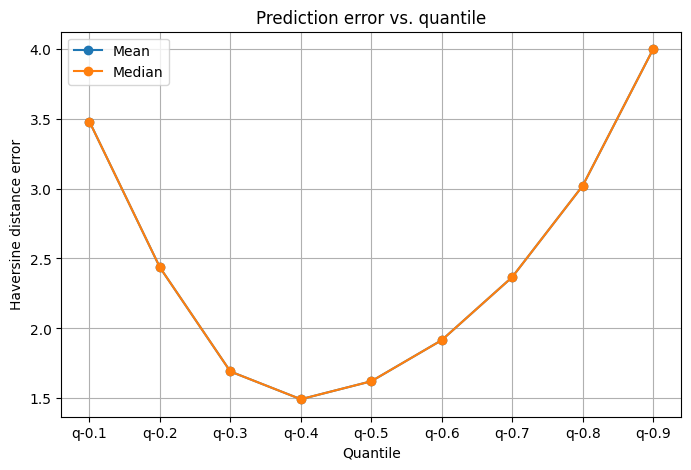

In [38]:
plt.figure(figsize=(8,5))
plt.plot(df_stats["quantile"], df_stats["mean"], marker="o", label="Mean")
plt.plot(df_stats["quantile"], df_stats["median"], marker="o", label="Median")
plt.xlabel("Quantile")
plt.ylabel("Haversine distance error")
plt.title("Prediction error vs. quantile")
plt.legend()
plt.grid(True)
plt.show()